In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj, interp_z, compute_thetae
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

teclevs = list(300. + 5*np.arange(70))

bclevs = list(-0.4+ 0.02*np.arange(100))
pclevs = list(-15.0 + np.arange(31))

dclevs = list(-20.0 + np.arange(41))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### READ SOLO FILES IN

In [2]:
paths = {}
# paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00'
# paths['solo2'] = '/work/wicker/Odin_scr/solo/bubble_3km_makenh_hdd125_C2000_00'
#paths['solo3'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt06_hdd125_C2000_00'
paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_pp2_hdd125_C2000_00'

solo = []
for key in paths:
    print("Reading: ",key)
    solo.append( read_solo_fields(paths[key], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=False) )


Reading:  solo1
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_3km_pp2_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_3km_pp2_hdd125_C2000_00/atmos_hifreq.nc 

 -->Computing finite difference 2D divergence

 -->Computing ThetaE 

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_3km_pp2_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------


In [3]:
n = 0

t0 = 10

solo_x = solo[0]['xc']*3
solo_z = solo[0]['zc']/1000.

buoy0  = container(solo_x, solo_z[t0,:,32,:], solo[0]['buoy'][t0,:,32,:])
dwdt0  = container(solo_x, solo_z[t0,:,32,:], solo[0]['dwdt'][t0,:,32,:])
buoy1  = container(solo_x, solo_z[t0,:,32,:], solo[1]['buoy'][t0,:,32,:])
dwdt1  = container(solo_x, solo_z[t0,:,32,:], solo[1]['dwdt'][t0,:,32,:])

thetae = solo[n]['thetae']

#plot_contour_row([container(thetae[0,:,32,:]),container(thetae[t0,:,32,:])], levels=teclevs, title='SOLO', xlabel='X (km)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);
plot_contour_row([buoy0, buoy1], levels=bclevs, title='SOLO', xlabel='X (km)', ylabel='Z (km)', extra_levels=[0.01,], cmap=plt.cm.viridis_r);
plot_contour_row([dwdt0, dwdt1], levels=bclevs, title='SOLO', xlabel='X (km)', ylabel='Z (km)', extra_levels=[0.01,], cmap=plt.cm.viridis_r);

t0 = 19
t1 = 21

w = solo[0]['w']
wc = container(solo_x, solo_z[t0,:,32,:], 0.01*solo[0]['w'][t0,:,32,:])
dwdt = (w[t1] - w[t0]) / (solo[n]['sec'][t1] - solo[n]['sec'][t0])
plot_contour_row([wc, container(solo_x, solo_z[t0,:,32,:], dwdt[:,32,:])], levels=bclevs, title='SOLO', xlabel='X (km)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);

KeyError: 'dwdt'

In [4]:
paths = {}
paths['cm1_3km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00'
#paths['cm1_2km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_test_hdd125_C2000_00'
#paths['cm1_1km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt01_hdd125_C2000_00'

cm1_hdd125 = []

for key in paths:
    print("Reading: ",key)
    cm1_hdd125.append( read_cm1_fields(paths[key], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=False) )

Reading:  cm1_3km_hdd125
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

 -->Could not find buoyant pressure gradient decomp

 -->Computing ThetaE 

 -->Computing finite difference 2D divergence

 Completed reading in:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------


10.0


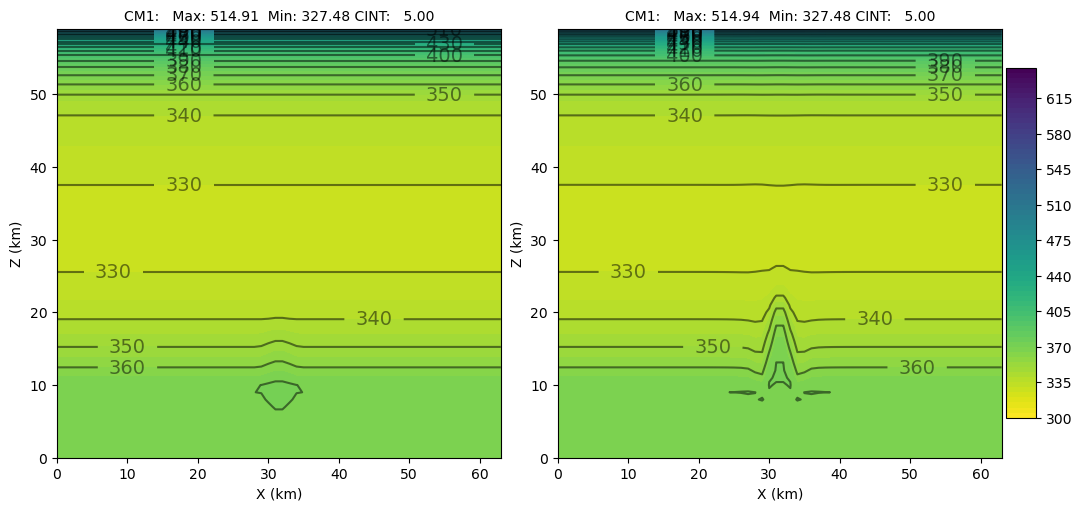

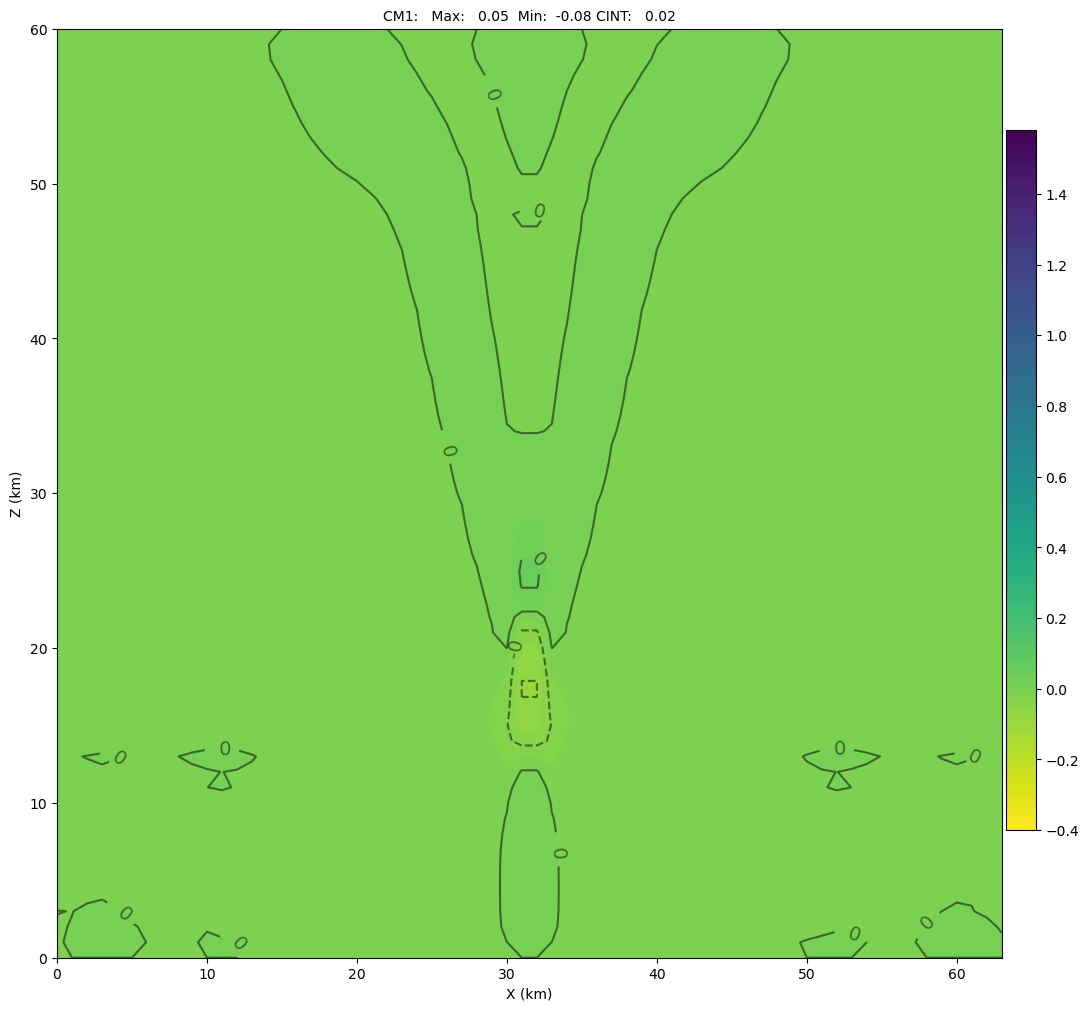

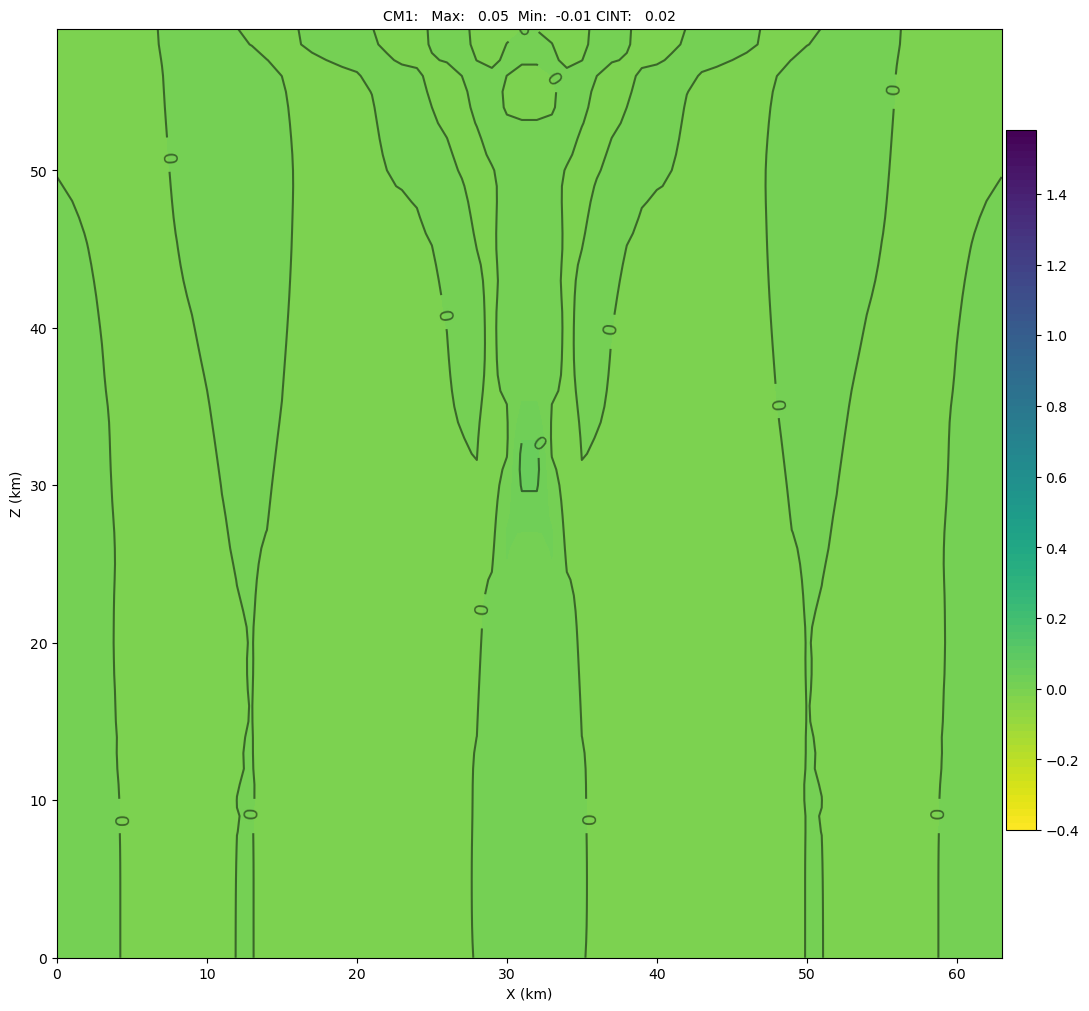

In [18]:
n = 1

buoy   = cm1_hdd125[n]['buoy']
buoy2  = cm1_hdd125[n]['dwdt']
pgradb = cm1_hdd125[n]['pgradb']
thetae = cm1_hdd125[n]['thetae']

t0 = 10

print(cm1_hdd125[n]['min'][t0])

plot_contour_row([container(thetae[0,:,32,:]),container(thetae[t0,:,32,:])], levels=teclevs, title='CM1', xlabel='X (km)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);
plot_contour_row([container(pgradb[t0,:,32,:])], levels=bclevs, title='CM1', xlabel='X (km)', ylabel='Z (km)', extra_levels=wclevs, xrange=[20,40], cmap=plt.cm.viridis_r);

t0 = 19
t1 = 21

w = cm1_hdd125[n]['w']
dwdt = (w[t1] - w[t0]) / (cm1_hdd125[n]['sec'][t1] - cm1_hdd125[n]['sec'][t0])
plot_contour_row([container(dwdt[:,32,:])], levels=bclevs, title='CM1', xlabel='X (km)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);



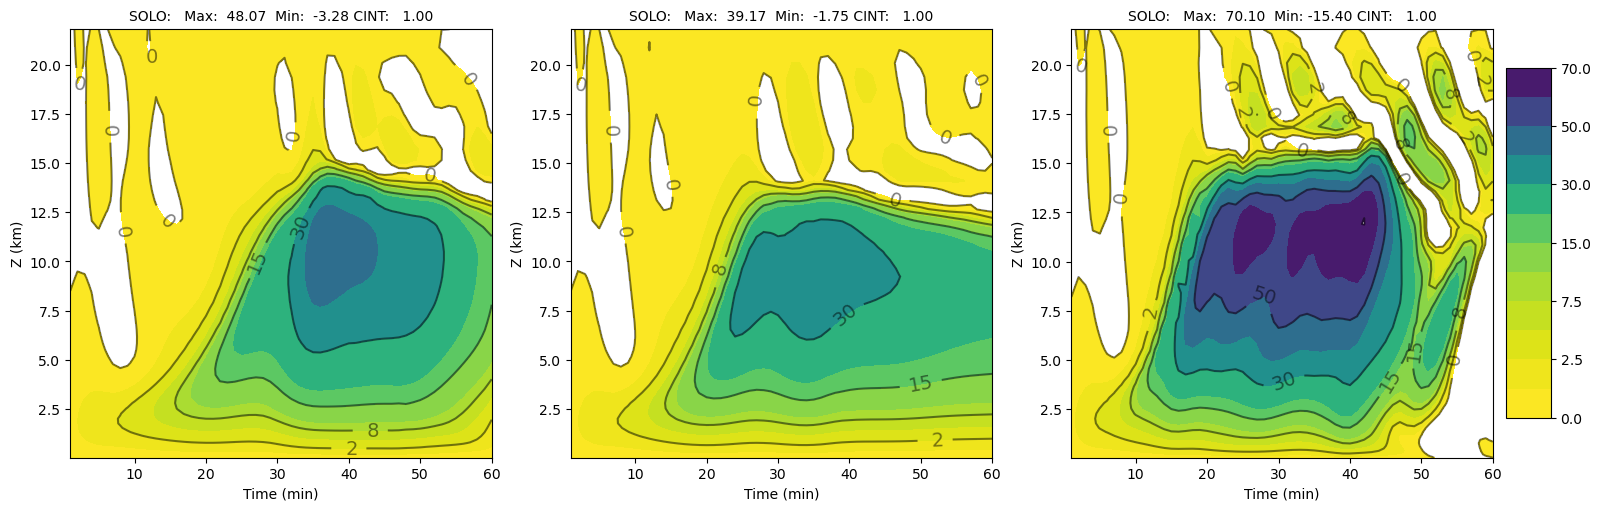

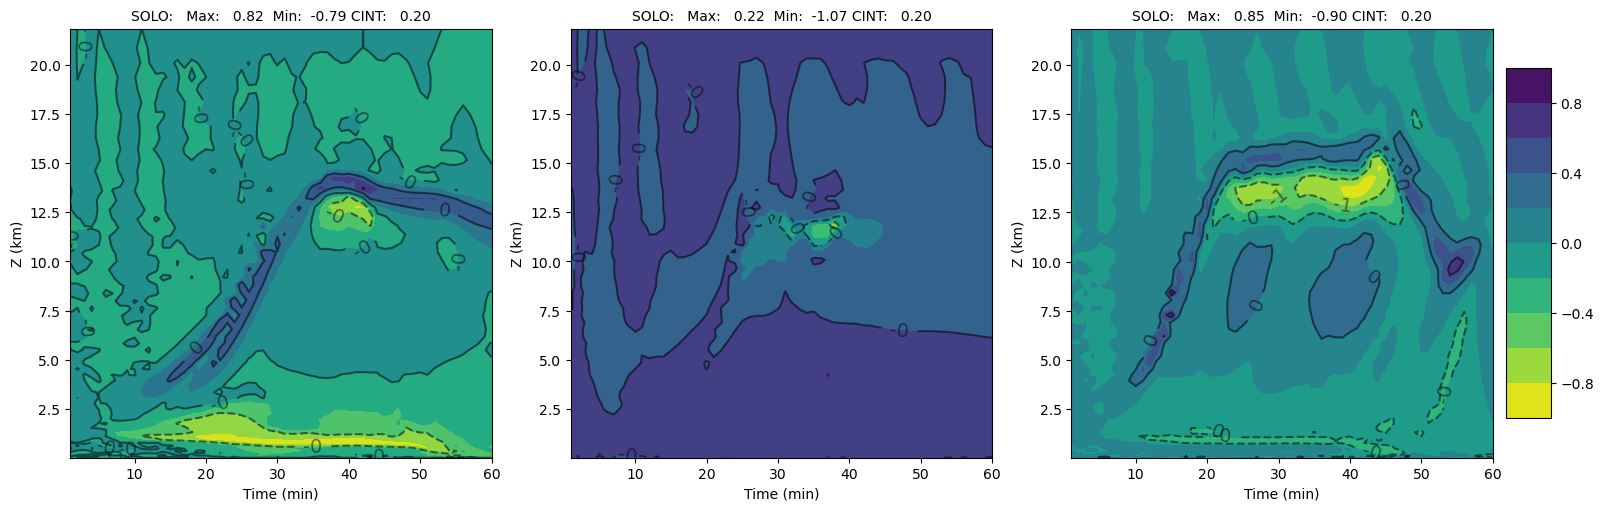

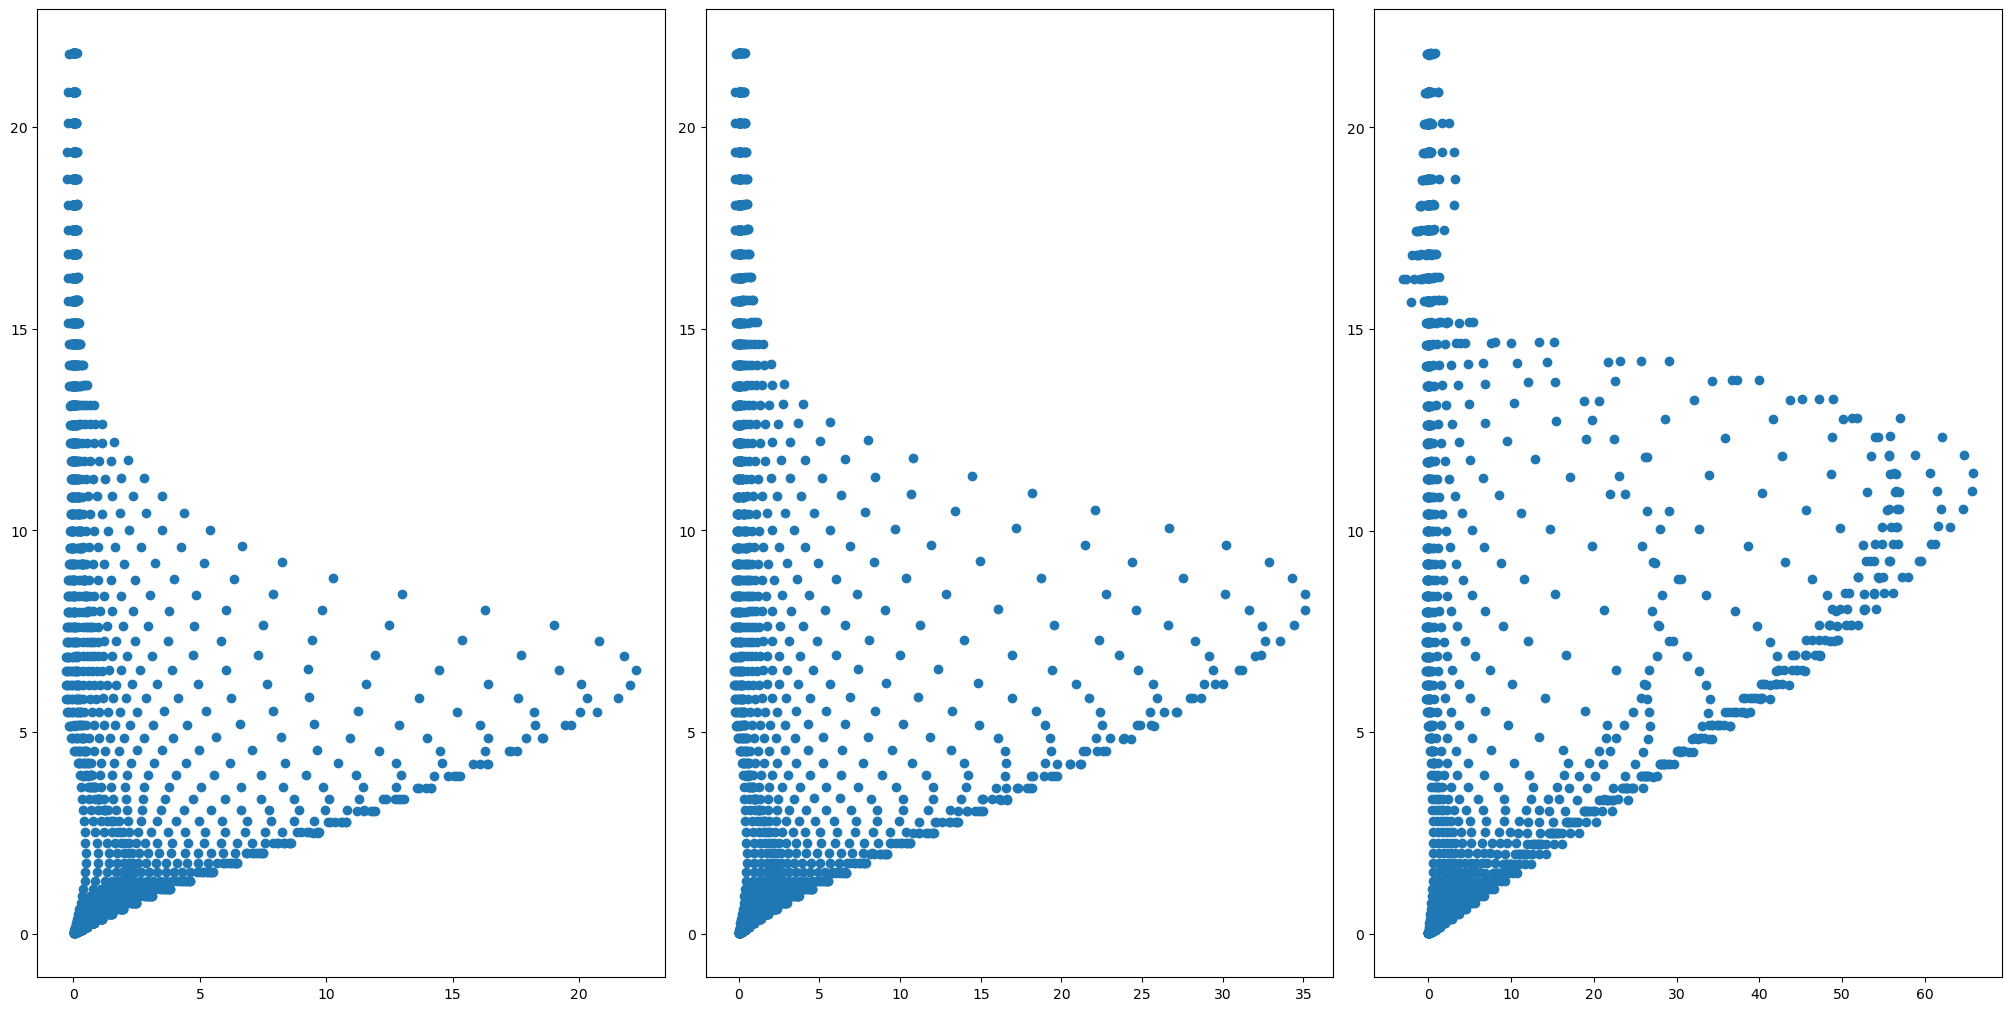

In [44]:
#

loc = [[32, 32], [32, 32], [96, 96], [32, 32]]

#loc = [[32, 32], [32, 32], [32, 32]]

time1 = solo_hdd125[0]['min']
time  = np.tile(time1, (60,1)).transpose()

wfields = []
pfields = []

for n in np.arange(3):

    iloc, jloc = loc[n][:]

    w_col = solo_hdd125[n]['w'][:,:,jloc, iloc]
    pp_col = solo_hdd125[n]['buoy2'][:,:,jloc, iloc]
    z_col = solo_hdd125[n]['hgt'][:,:,jloc, iloc] * 0.001

    wfields.append(container(time, z_col, w_col))
    pfields.append(container(time, z_col, pp_col))

plot_contour_row(wfields, levels=wclevs, title='SOLO', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);
plot_contour_row(pfields, title='SOLO', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=0.2);

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

tlim = 25

for n in np.arange(3):

    iloc, jloc = loc[n][:]

    w_col = solo_hdd125[n]['w'][:,:,jloc, iloc]
    # th_col = solo_hdd125[n]['pert_nh'][:,:,jloc, iloc]/100.
    z_col = solo_hdd125[n]['hgt'][:,:,jloc, iloc] * 0.001

    ax[n].scatter(w_col[:tlim,:], z_col[:tlim,:])




In [40]:
# CM1 multi-resolution plots
#
time1 = cm1_hdd125[0]['min']
time  = np.tile(time1, (60,1)).transpose()

loc = [[32, 32], [48, 48], [96, 96]]

wfields = []
pfields = []

for n in np.arange(3):

    iloc, jloc = loc[n][:]
    
    w_col = cm1_hdd125[n]['w'][:,:,jloc, iloc]
    pp_col = cm1_hdd125[n]['pert_p'][:,:,jloc, iloc]/100.
    z1d    = cm1_hdd125[n]['hgt']
    z_col  = np.tile(z1d, (time1.shape[0],1))

    wfields.append(container(time, z_col, w_col))
    pfields.append(container(time, z_col, pp_col))

plot_contour_row(wfields, levels=wclevs, title='CM1', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);
plot_contour_row(pfields, title='CM1', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=0.1);

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

tlim = 40

for n in np.arange(3):

    iloc, jloc = loc[n][:]

    w_col = cm1_hdd125[n]['w'][:,:,jloc, iloc]
    # th_col = solo_hdd125[n][0]['pert_nh'][:,:,jloc, iloc]/100.
    z1d    = cm1_hdd125[n][1].zh.values[:]
    z_col  = np.tile(z1d, (time1.shape[0],1))

    ax[n].scatter(w_col[:tlim,:], z_col[:tlim,:], s=0.5, c='b' )

    w_col = solo_hdd125[n][0]['w'][:,:,jloc, iloc]
    # th_col = solo_hdd125[n][0]['pert_nh'][:,:,jloc, iloc]/100.
    z_col = solo_hdd125[n][0]['hgt'][:,:,jloc, iloc] * 0.001

    ax[n].scatter(w_col[:tlim+1,:], z_col[:tlim+1,:], s=0.5, c='r')

    ax[n].set_xlabel('W m/s')



KeyError: 1

In [10]:
print(cm1_hdd125[n][0].keys())
print(solo_hdd125[n][0].keys())

dict_keys(['div2d', 'w', 'accum_prec', 'theta', 'qv', 'qc', 'pii', 'hgt', 'pert_th', 'qr', 'v', 'u', 'temp', 'vvort', 'pert_p'])
dict_keys(['pres', 'div2d', 'w', 'accum_prec', 'theta', 'qv', 'qc', 'pii', 'hgt', 'pert_th', 'qr', 'v', 'u', 'temp', 'vvort', 'pert_p', 'pert_nh'])


In [47]:
# CM1 multi-resolution plots
#

from tools.cbook import interp_z

zlevels = (100. + 250.*np.arange(70))/1000.

time = cm1_hdd125[0]['min']/60.

t0 = 10
res = [3,2,1]
wlist, dlist, thlist, pplist, qclist = [],[],[],[],[]

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

for n in np.arange(3):

    fields = []
    
    tloc, jloc = loc[n][:]
    
    w_cm1 = cm1_hdd125[n]['pert_th'][tloc+2,:,jloc, :]
    z_cm1 = cm1_hdd125[n]['hgt']
    x_cm1 = cm1_hdd125[n]['xh'].values

    w_cinterp = interp_z(w_cm1, z_cm1, zlevels)

    fields.append(container(x_cm1, zlevels, w_cinterp))

    x_solo = solo_hdd125[n]['grid_xt'].values*res[n]
    z_solo = solo_hdd125[n]['hgt'][tloc,:,jloc, :] / 1000.
    w_solo = solo_hdd125[n]['pert_th'][tloc,:,:,:].max(axis=2)

    w_sinterp = interp_z(w_solo, z_solo, zlevels)

    fields.append(container(x_solo, zlevels, w_sinterp))

    wdiff = np.where(w_sinterp > 5, w_sinterp, 0.0) - np.where(w_cinterp > 5, w_cinterp, 0.0)[:,:-1]

    fields.append(container(x_solo, zlevels, wdiff))

    plot_contour_row(fields, levels=wclevs, title='LEFT:C  RIGHT:S', xlabel='Time (min)', ylabel='Z (km)', 
                     range=[76,116], extra_levels=wclevs, cmap=plt.cm.viridis_r);



KeyError: 'xh'

In [ ]:
from tools.cbook import interp_z

zlevels = (100. + 250.*np.arange(70))/1000.

time = cm1_hdd125[0][1]['time']/60.

t0 = 10
res = [3,2,1]
wlist, dlist, thlist, pplist, qclist = [],[],[],[],[]

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

for n in np.arange(1):

    fields = []
    
    tloc, jloc = loc[n][:]
    
    w_cm1 = cm1_hdd125[n][0]['pert_th'][tloc+1,:,jloc, :]
    z_cm1 = cm1_hdd125[n][1].zh.values[:]
    x_cm1 = cm1_hdd125[n][1]['xh'].values

    w_cinterp = interp_z(w_cm1, z_cm1, zlevels)

    fields.append(container(x_cm1, zlevels, w_cinterp))

    x_solo = solo_hdd125[n][1]['grid_xt'].values*res[n]
    z_solo = solo_hdd125[n][0]['hgt'][tloc,:,jloc, :] / 1000.
    w_solo = solo_hdd125[n][0]['pert_th'][tloc,:,:,:].max(axis=2)

    w_sinterp = interp_z(w_solo, z_solo, zlevels)

    fields.append(container(x_solo, zlevels, w_sinterp))

    wdiff = np.where(w_sinterp > 5, w_sinterp, 0.0) - np.where(w_cinterp > 5, w_cinterp, 0.0)[:,:-1]

    fields.append(container(x_solo, zlevels, wdiff))

    # plot_contour_row(fields, levels=wclevs, title='LEFT:C  RIGHT:S', xlabel='Time (min)', ylabel='Z (km)', 
    #                  range=[76,116], extra_levels=wclevs, cmap=plt.cm.viridis_r);

(60, 63)
(60, 95)
(60, 191)


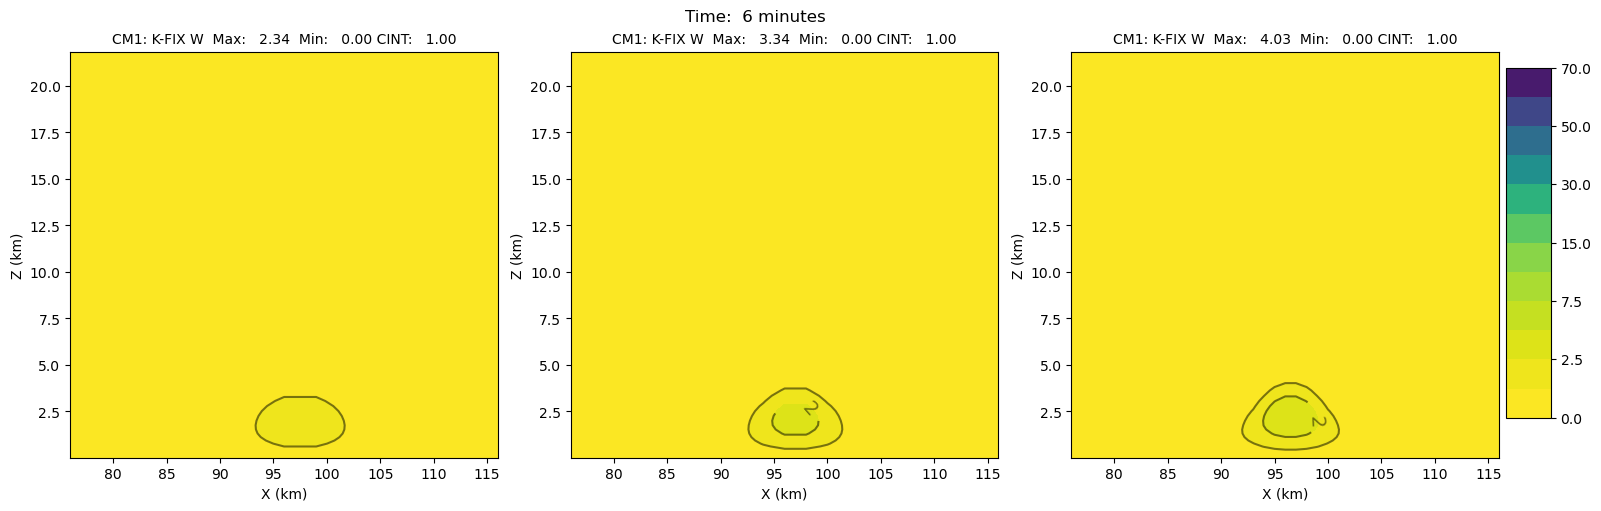

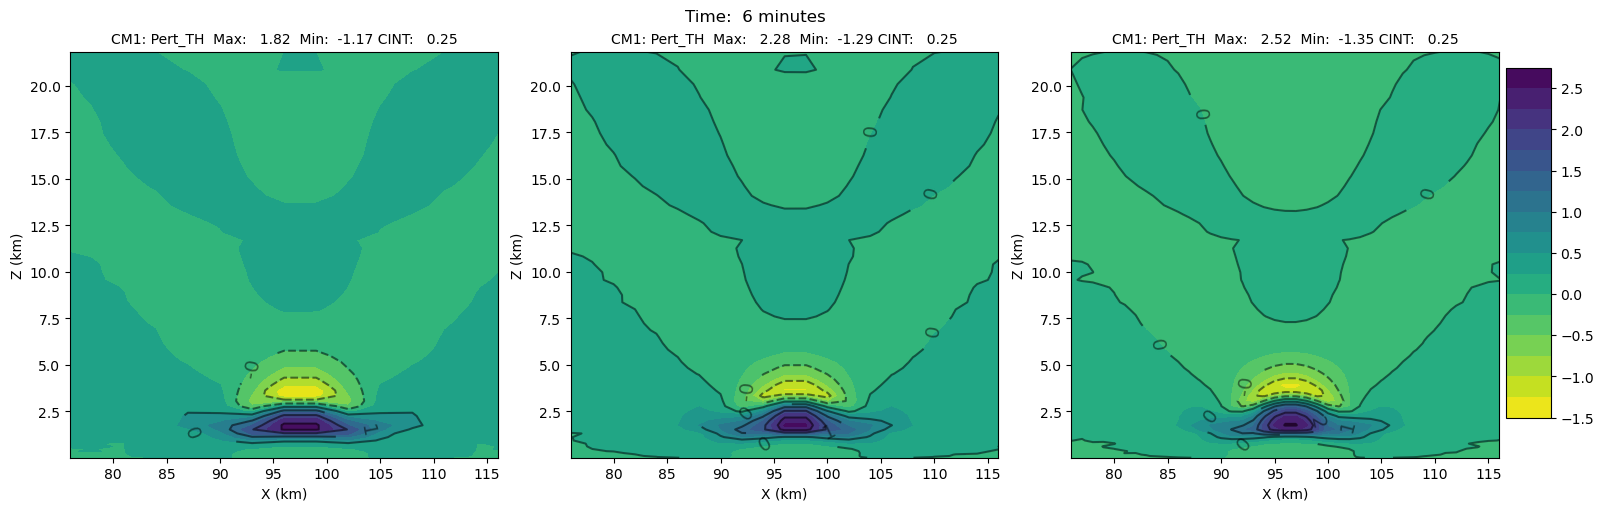

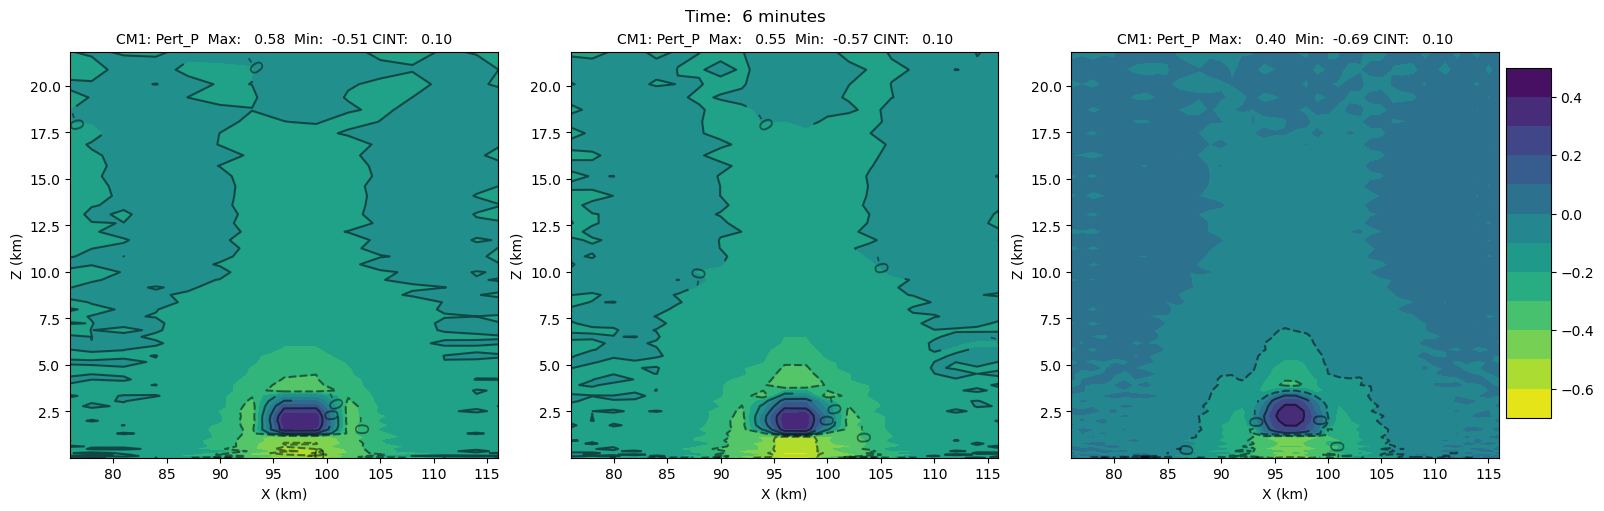

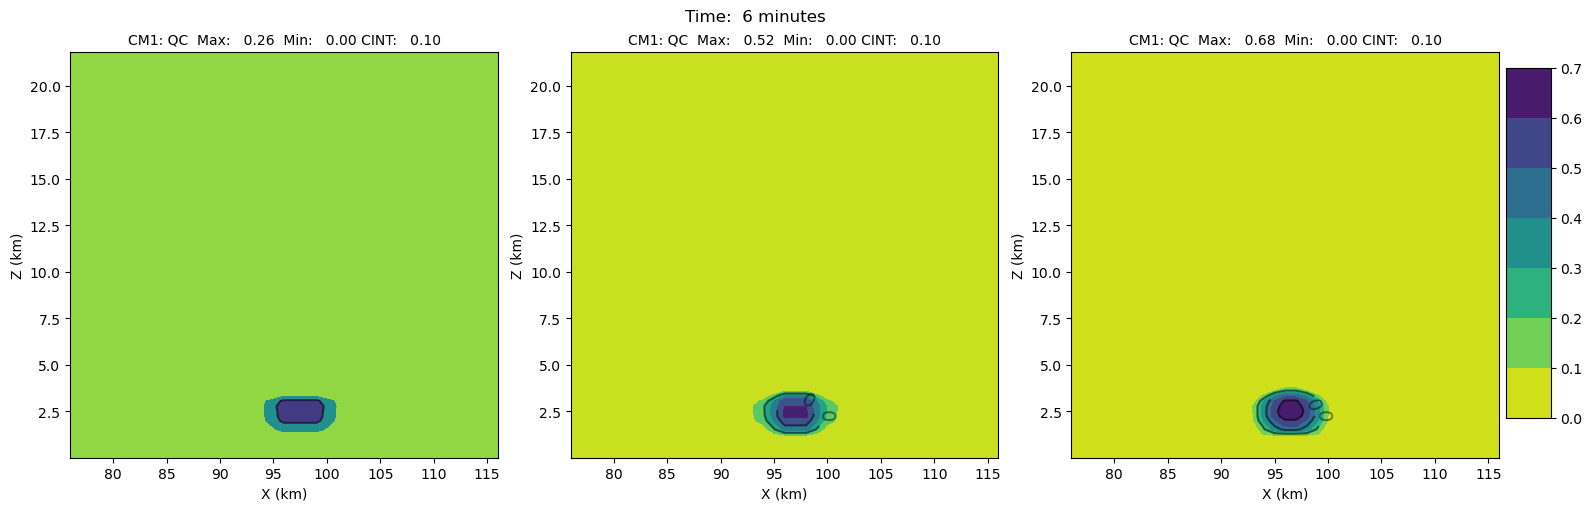

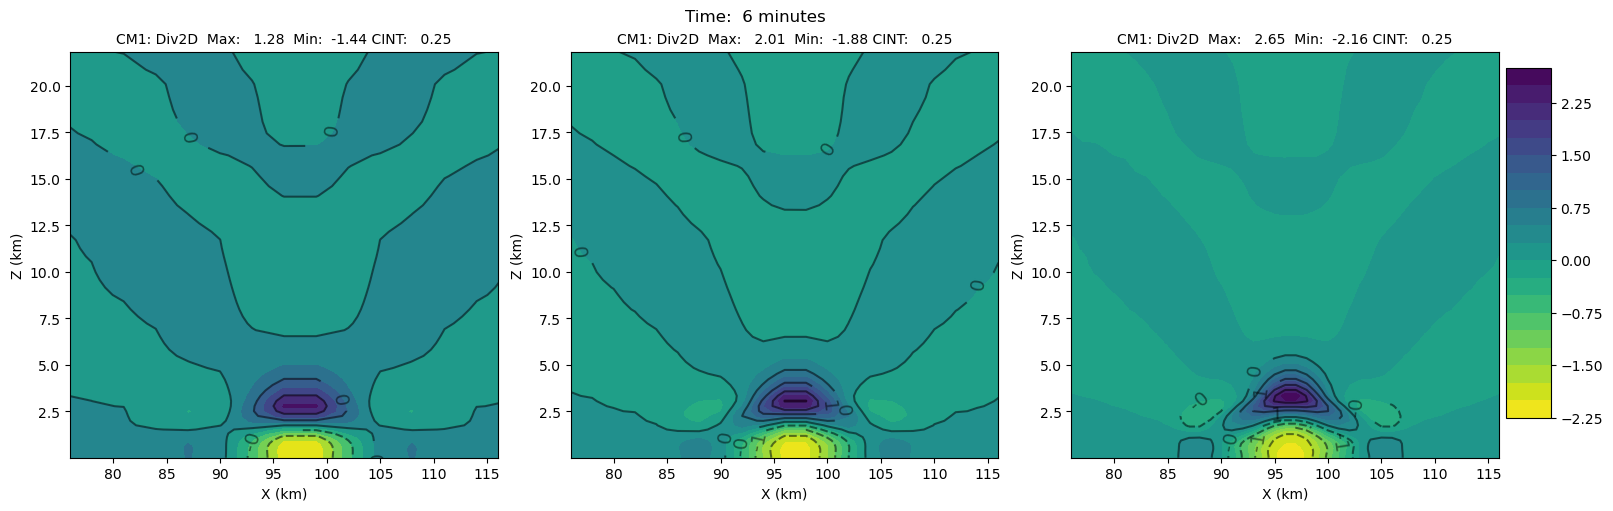

In [62]:
################## HDDD 

t0 = 6
res = [3,2,1]
wlist, dlist, thlist, pplist, qclist = [],[],[],[],[]

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

for n, m in enumerate([0,1,2]):

    tloc, jloc = loc[n][:]

    suptitle = "Time:  %d minutes" % int(time1[tloc])

    z_col = solo_hdd125[m][0]['hgt'][tloc,:,jloc, :] * 0.001
    x1 = solo_hdd125[n][1]['grid_xt'].values*res[n]
    x  = np.tile(x1, (z_col.shape[0],1))

    w  = solo_hdd125[m][0]['w'][tloc,:,:,:].max(axis=2)
    d  = solo_hdd125[m][0]['div2d'][tloc,:,jloc,:] / res[n]
    th = solo_hdd125[m][0]['pert_th'][tloc,:,jloc,:]
    pp = solo_hdd125[m][0]['pert_nh'][tloc,:,jloc,:]/100.
    qc = solo_hdd125[m][0]['qc'][tloc,:,:,:].max(axis=2)*1000.
    print(qc.shape)
        
    wlist.append(container(x, z_col, w))
    dlist.append(container(x, z_col, d))
    thlist.append(container(x, z_col, th))
    pplist.append(container(x, z_col, pp))
    qclist.append(container(x, z_col, qc))
        
# Compare exact and calculated derivative:

plot_contour_row(wlist,  levels=wclevs, title=title, suptitle=suptitle, var='K-FIX W',       range=[76,116], xlabel='X (km)', ylabel='Z (km)', cl_levels=wclevs);
plot_contour_row(thlist,                title=title, suptitle=suptitle, var='Pert_TH', range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25)# cl_levels=tclevs[::2]);
plot_contour_row(pplist,                title=title, suptitle=suptitle, var='Pert_P',  range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(qclist,                title=title, suptitle=suptitle, var='QC',      range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(dlist,                 title=title, suptitle=suptitle, var='Div2D',   range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25);

### CM1 READ IN FILES

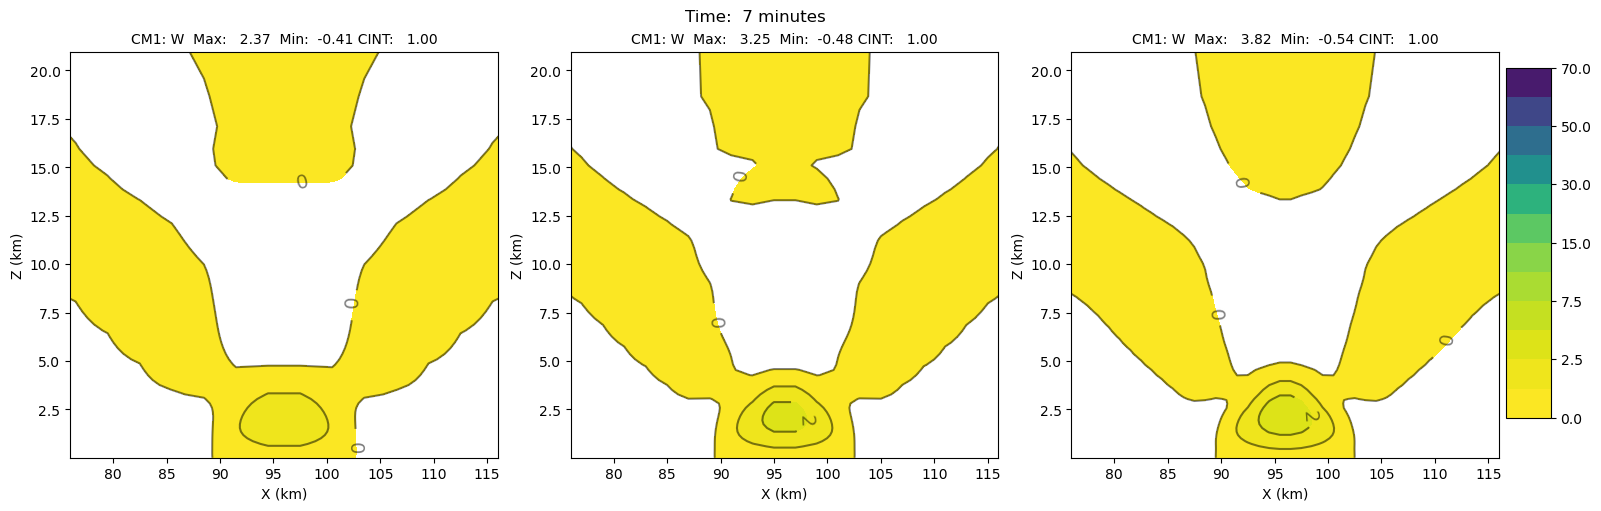

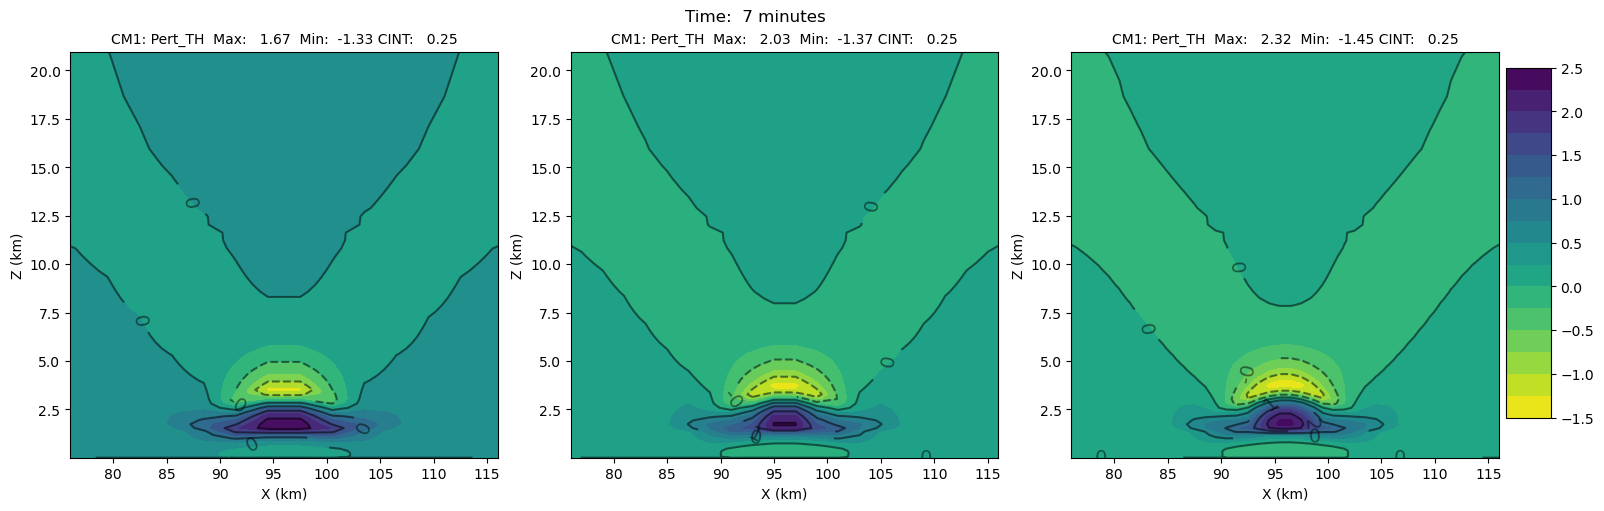

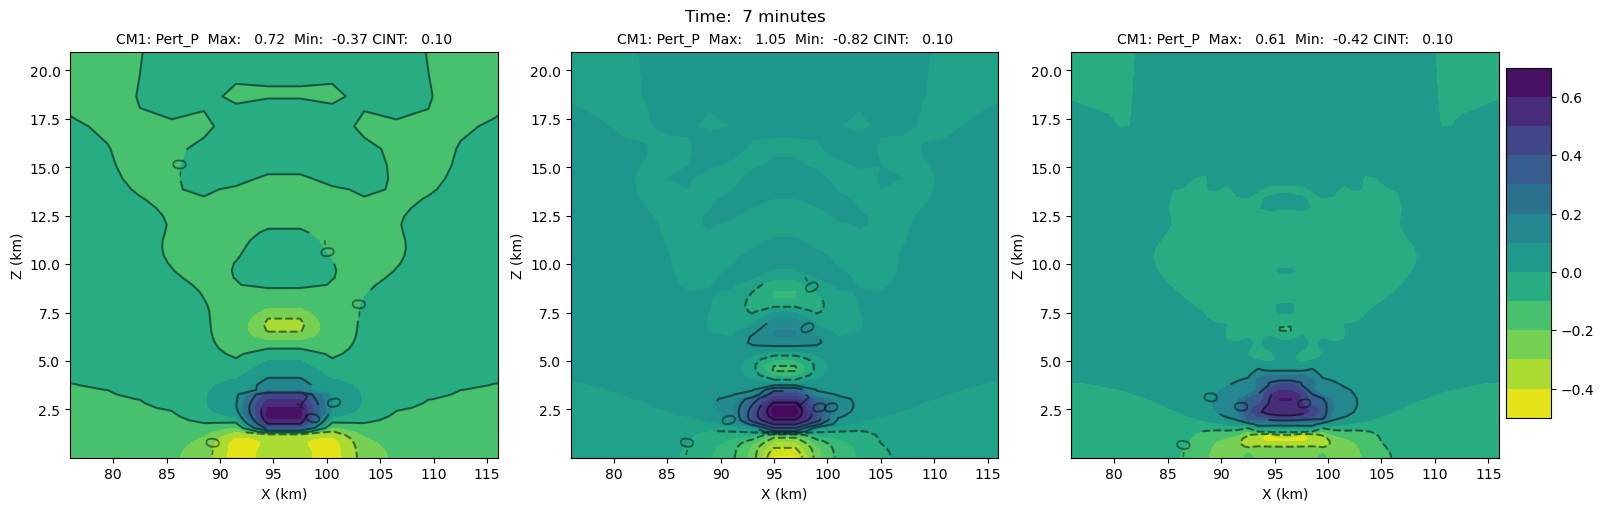

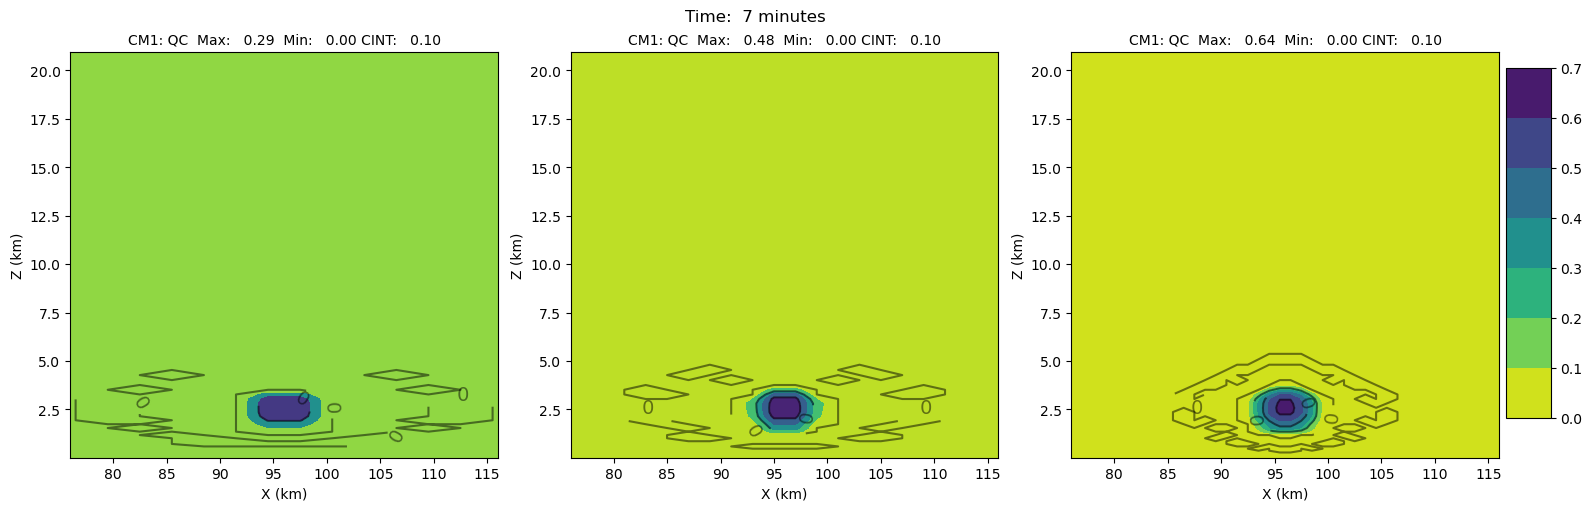

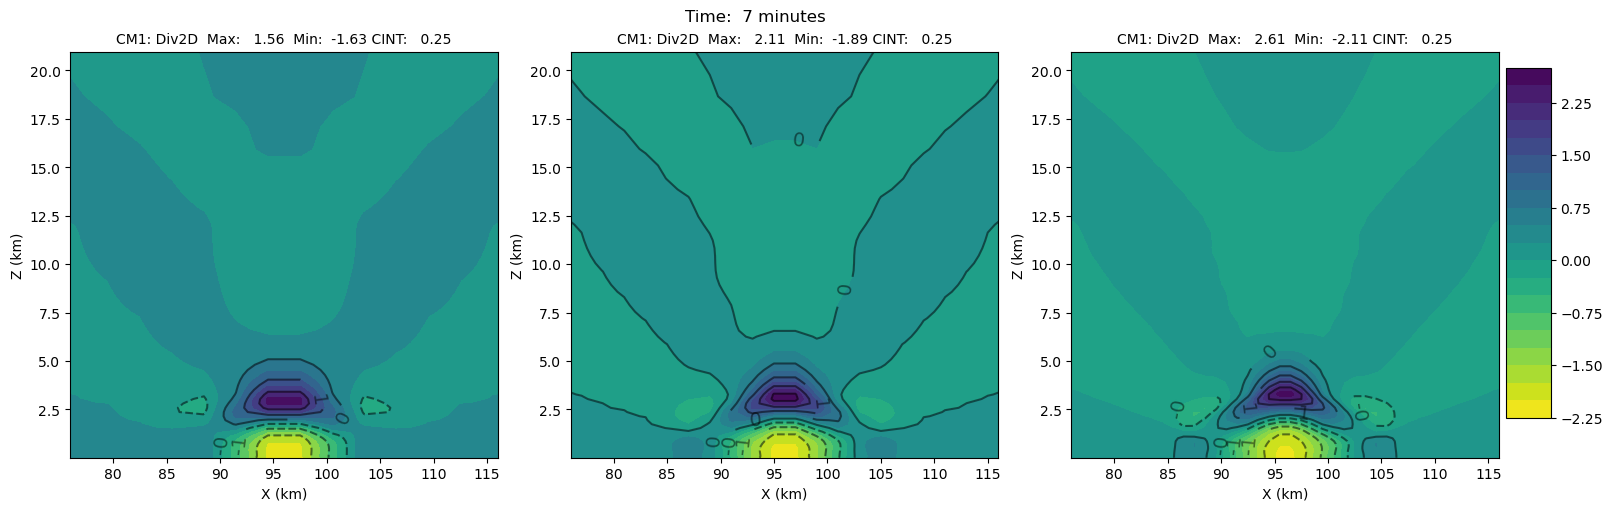

In [61]:
# CM1 plots

t0 = 7

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

time1 = cm1_hdd125[0][1]['time']/60.

title='CM1'

wlist = []
dlist = []
thlist = []
pplist = []
qclist = []

for n in np.arange(3):

    tloc, jloc = loc[n][:]

    suptitle = "Time:  %d minutes" % int(time1[tloc])

    z2d = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]*0.001
    x1  = cm1_hdd125[n][1]['xh']
    x   = np.tile(x1, (z2d.shape[0],1))
    d   = cm1_hdd125[n][0]['div2d'][tloc,:,jloc,:] 
    w   = cm1_hdd125[n][0]['w'][tloc,:,jloc, :]
    thp = cm1_hdd125[n][0]['pert_th'][tloc,:,jloc, :]
    pp  = cm1_hdd125[n][0]['pert_p'][tloc,:,jloc, :] / 100.
    qc  = cm1_hdd125[n][0]['qc'][tloc,:,jloc, :] * 1000.
        
    wlist.append(container(x, z2d, w))
    dlist.append(container(x, z2d, d))
    thlist.append(container(x, z2d, thp))
    pplist.append(container(x, z2d, pp))
    qclist.append(container(x, z2d, qc))
    
    
# Compare exact and calculated derivative:

plot_contour_row(wlist,  levels=wclevs, title=title, suptitle=suptitle, var='W',       range=[76,116], xlabel='X (km)', ylabel='Z (km)', cl_levels=wclevs);
plot_contour_row(thlist,                title=title, suptitle=suptitle, var='Pert_TH', range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25)# cl_levels=tclevs[::2]);
plot_contour_row(pplist,                title=title, suptitle=suptitle, var='Pert_P',  range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(qclist,                title=title, suptitle=suptitle, var='QC',      range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(dlist,                 title=title, suptitle=suptitle, var='Div2D',   range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25);


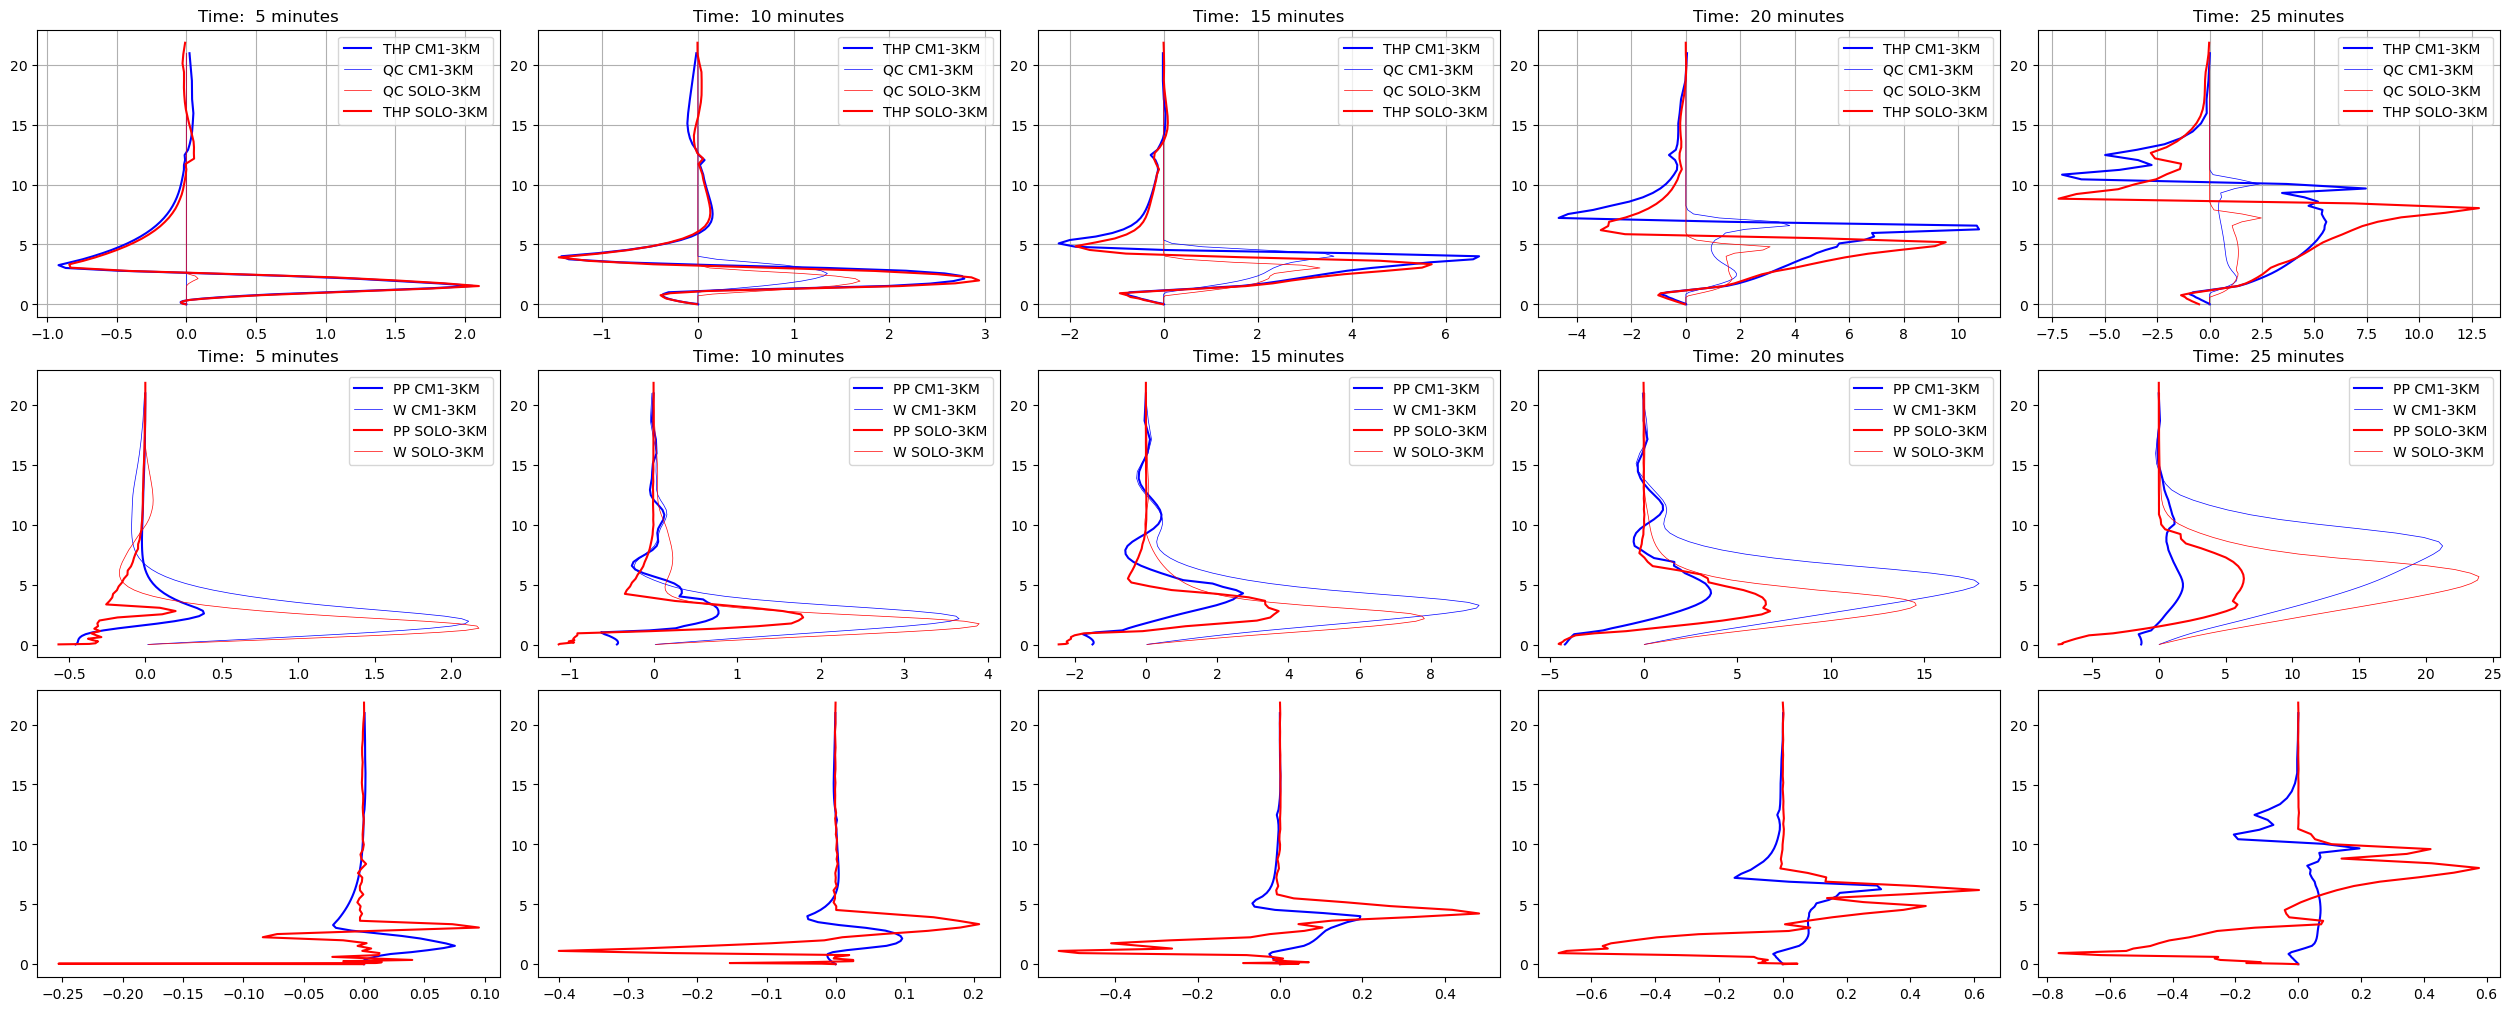

In [52]:
# Updraft Core plots

tplot = [5, 10, 15, 20, 25]

cm1_time = cm1_hdd125[0]['min']

fig, axes = fig, axes = plt.subplots(3,len(tplot), constrained_layout=True, figsize=(5*len(tplot),10))

for n, tloc in enumerate(tplot):

    iloc, jloc = 32, 32

    title = "Time:  %d minutes" % int(cm1_time[tloc])

    z_cm1   = cm1_hdd125[0]['hgt'][tloc, :, jloc, iloc]*0.001
    thp_cm1 = cm1_hdd125[0]['pert_th'][tloc,:,jloc, iloc]
    pp_cm1  = cm1_hdd125[0]['pert_p'][tloc,:,jloc, iloc] / 100.
    qc_cm1  = cm1_hdd125[0]['qc'][tloc,:,jloc, iloc] * 1000.
    w_cm1   = cm1_hdd125[0]['w'][tloc,:,jloc, iloc]
    b_cm1   = cm1_hdd125[0]['buoy'][tloc,:,jloc, iloc]


    z_solo   = solo_hdd125[0]['hgt'][tloc-1,:,jloc, iloc] * 0.001
    thp_solo = solo_hdd125[0]['pert_th'][tloc-1,:,jloc,iloc]
    pp_solo  = solo_hdd125[0]['pert_nh'][tloc,:,jloc,iloc]/100.
    qc_solo  = solo_hdd125[0]['qc'][tloc,:,jloc,iloc]*1000.
    w_solo   = solo_hdd125[0]['w'][tloc,:, jloc, iloc]
    b_solo   = solo_hdd125[0]['buoy2'][tloc,:, jloc, iloc]

    axes[0,n].plot(thp_cm1, z_cm1, color='b', label='THP CM1-3KM')
    axes[0,n].plot(qc_cm1, z_cm1, color='b', linewidth=0.5, label='QC CM1-3KM')
    axes[0,n].plot(qc_solo, z_cm1, color='r', linewidth=0.5, label='QC SOLO-3KM')
    axes[0,n].plot(thp_solo, z_solo, color='r', label='THP SOLO-3KM')
    axes[0,n].set_title(title)
    axes[0,n].legend()
    axes[0,n].grid()

    axes[1,n].plot(pp_cm1,  z_cm1, color='b', label='PP CM1-3KM')
    axes[1,n].plot(w_cm1,   z_cm1, color='b', linewidth=0.5, label='W CM1-3KM')
    axes[1,n].plot(pp_solo, z_solo, color='r', label='PP SOLO-3KM')
    axes[1,n].plot(w_solo,  z_cm1, color='r', linewidth=0.5, label='W SOLO-3KM')
    axes[1,n].grid()

    axes[2,n].plot(b_cm1, z_cm1, color='b', label='B CM1-3KM')
    axes[2,n].plot(b_solo, z_solo, color='r', label='B SOLO-3KM')
    axes[1,n].grid()

    axes[1,n].set_title(title)
    axes[1,n].legend()


plt.show()

    # d   = cm1_hdd125[n][0]['div2d'][tloc,:,jloc,:] 
    # w   = cm1_hdd125[n][0]['w'][tloc,:,jloc, :]

    # pp  = cm1_hdd125[n][0]['pert_p'][tloc,:,jloc, :] / 100.
    # qc  = cm1_hdd125[n][0]['qc'][tloc,:,jloc, :] * 1000.


18.485563
19.875565


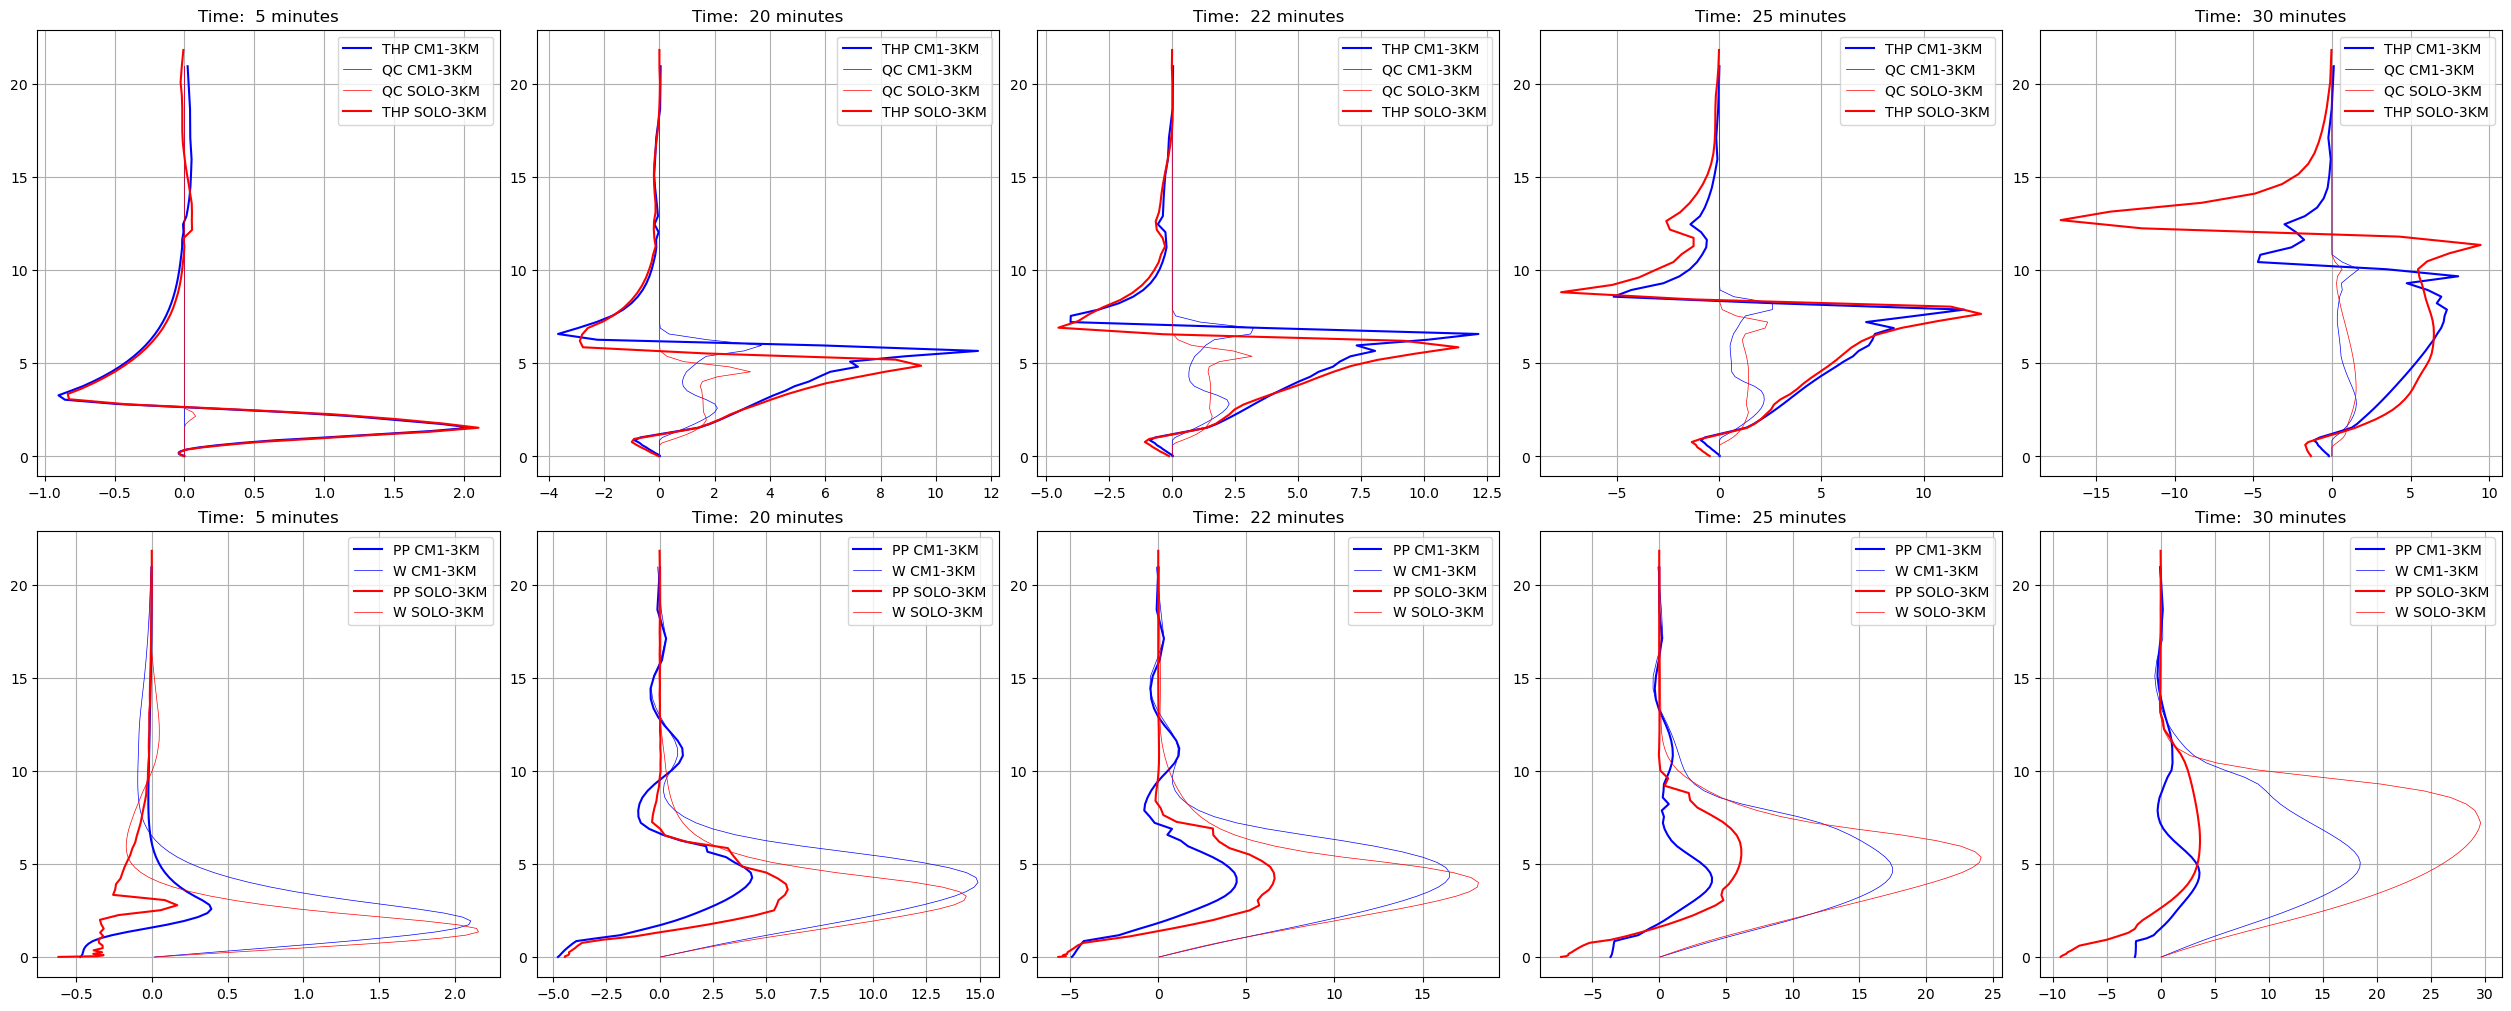

In [179]:
# Updraft Core plots

print(cm1_test[0][0]['w'][:,:,jloc, iloc].max())
print(cm1_test[1][0]['w'][:,:,jloc, iloc].max())

m = 1

tplot = [5, 20, 22, 25, 30]

cm1_time = cm1_hdd125[0][1]['time']/60.

fig, axes = fig, axes = plt.subplots(2,len(tplot), constrained_layout=True, figsize=(5*len(tplot),10))

for n, tloc in enumerate(tplot):

    iloc, jloc = 32, 32

    title = "Time:  %d minutes" % int(cm1_time[tloc])

    z_cm1   = cm1_test[m][0]['hgt'][tloc, :, jloc, iloc]*0.001
    thp_cm1 = cm1_test[m][0]['pert_th'][tloc,:,jloc, iloc]
    pp_cm1  = cm1_test[m][0]['pert_p'][tloc,:,jloc, iloc] / 100.
    qc_cm1  = cm1_test[m][0]['qc'][tloc,:,jloc, iloc] * 1000.
    w_cm1   = cm1_test[m][0]['w'][tloc,:,jloc, iloc]

    z_solo   = solo_hdd125[0][0]['hgt'][tloc-1,:,jloc, iloc] * 0.001
    thp_solo = solo_hdd125[0][0]['pert_th'][tloc-1,:,jloc,iloc]
    pp_solo  = solo_hdd125[0][0]['pert_nh'][tloc,:,jloc,iloc]/100.
    qc_solo  = solo_hdd125[0][0]['qc'][tloc,:,jloc,iloc]*1000.
    w_solo   = solo_hdd125[0][0]['w'][tloc,:, jloc, iloc]

    axes[0,n].plot(thp_cm1, z_cm1, color='b', label='THP CM1-3KM')
    axes[0,n].plot(qc_cm1, z_cm1, color='b', linewidth=0.5, label='QC CM1-3KM')
    axes[0,n].plot(qc_solo, z_cm1, color='r', linewidth=0.5, label='QC SOLO-3KM')
    axes[0,n].plot(thp_solo, z_solo, color='r', label='THP SOLO-3KM')
    axes[0,n].set_title(title)
    axes[0,n].legend()
    axes[0,n].grid()

    axes[1,n].plot(pp_cm1, z_cm1, color='b', label='PP CM1-3KM')
    axes[1,n].plot(w_cm1, z_cm1, color='b', linewidth=0.5, label='W CM1-3KM')
    axes[1,n].plot(pp_solo, z_solo, color='r', label='PP SOLO-3KM')
    axes[1,n].plot(w_solo, z_cm1, color='r', linewidth=0.5, label='W SOLO-3KM')
    axes[1,n].grid()

    axes[1,n].set_title(title)
    axes[1,n].legend()


plt.show()

In [98]:
tplot = [5, 10, 15, 20, 25, 30, 35]

cm1_time = cm1_hdd125[0][1]['time']/60.

#fig, axes = fig, axes = plt.subplots(2,len(tplot), constrained_layout=True, figsize=(5*len(tplot),10))

run = 0

for n, tloc in enumerate(tplot):

    iloc, jloc = 32, 32

    title = "Time:  %d minutes" % int(cm1_time[tloc])

    z_cm1   = cm1_hdd125[run][0]['hgt'][tloc, :, jloc, iloc]*0.001
    thp_cm1 = cm1_hdd125[run][0]['pert_th'][tloc,:]
    w_cm1   = cm1_hdd125[run][0]['w'][tloc,:,:,:]
    theta0  = cm1_hdd125[run][0]['theta'][0,:,0,0]

    nz    = thp_cm1.shape[0]
    R     = np.zeros((nz,))
    B     = np.zeros((nz,))
    alpha = np.zeros((nz,))

    wthresh = 0.1

    for k in np.arange(nz):

        # Buoyancy calculation
        if k > 0 and k < nz-1:
            theta_avg = (thp_cm1[k,jloc,iloc] + thp_cm1[k-1,jloc,iloc])/(theta0[k]+theta0[k-1])
            B[k] = 9.801 * theta_avg * (z_cm1[k] - z_cm1[k-1])*1000.
            B[k] = max(B[k], 0.0)

        # Radius calculation
        
        R[k] = np.sqrt(9.*np.sum(thp_cm1[k] > 1.0))
        
        if( R[k] > 0.1 ): 
            H = z_cm1[k]
        
        wmax   = w_cm1[k,:,:].max()
        if wmax > wthresh:
            wslice = w_cm1[k,:,:]
            wmean  = wslice[wslice > wthresh].flatten()
            alpha[k] = wmean.mean() / wmax
            #print(k, alpha[k], wmax)

        # Buoyancy calculation
        if k > 0 and k < nz-1:
            theta_avg = (thp_cm1[k,jloc,iloc] + thp_cm1[k-1,jloc,iloc])/(theta0[k]+theta0[k-1])
            B[k] = 9.801 * theta_avg * (z_cm1[k] - z_cm1[k-1])*1000.
            B[k] = max(B[k], 0.0)

    Rsum = R[B>0.1].mean()
    CAPE = B.sum()
    alpha_m = alpha.mean()
    wn = np.sqrt(2.0*CAPE / (1.0 + 4.*(alpha_m*Rsum/H)**2))
     
    print("CM1  Time: %2.0d min Wmax: %5.2f CAPE:  %8.2f H: %8.2f  R: %8.2f  Alpha: %4.2f Wn: %5.2f" % (tloc, w_cm1.max(), CAPE, Rsum, H, alpha_m, wn))

    z_solo   = solo_hdd125[0][0]['hgt'][tloc-1,:,jloc, iloc] * 0.001
    thp_solo = solo_hdd125[0][0]['pert_th'][tloc-1,:]
    w_solo   = solo_hdd125[0][0]['w'][tloc,:]
    theta0   = solo_hdd125[run][0]['theta'][0,:,0,0]

    nz    = thp_cm1.shape[0]
    R     = np.zeros((nz,))
    B     = np.zeros((nz,))
    alpha = np.zeros((nz,))

    for k in np.arange(nz):

        # Buoyancy calculation
        if k > 0 and k < nz-1:
            theta_avg = (thp_solo[k,jloc,iloc] + thp_solo[k-1,jloc,iloc])/(theta0[k]+theta0[k-1])
            B[k] = 9.801 * theta_avg * (z_solo[k] - z_solo[k-1])*1000.
            B[k] = max(B[k], 0.0)

        # Radius calculation
        
        R[k] = np.sqrt(9.*np.sum(thp_solo[k] > 1.0))
        
        if( R[k] > 0.1 ): 
            H = z_solo[k]
        
        wmax   = w_solo[k,:,:].max()
        if wmax > wthresh:
            wslice = w_solo[k,:,:]
            wmean  = wslice[wslice > wthresh].flatten()
            alpha[k] = wmean.mean() / wmax
            #print(k, alpha[k], wmax)

        # Buoyancy calculation
        if k > 0 and k < nz-1:
            theta_avg = (thp_solo[k,jloc,iloc] + thp_solo[k-1,jloc,iloc])/(theta0[k]+theta0[k-1])
            B[k] = 9.801 * theta_avg * (z_solo[k] - z_solo[k-1])*1000.
            B[k] = max(B[k], 0.0)

    Rsum = R[B>0.1].mean()
    CAPE = B.sum()
    alpha_m = alpha.mean()
    wn = np.sqrt(2.0*CAPE / (1.0 + 4.*(alpha_m*Rsum/H)**2))
     
    print("SOLO Time: %2.0d min Wmax: %5.2f CAPE:  %8.2f H: %8.2f  R: %8.2f  Alpha: %4.2f Wn: %5.2f" % (tloc, w_solo.max(), CAPE, Rsum, H, alpha_m, wn))
    print("============================")


CM1  Time:  5 min Wmax:  2.12 CAPE:     83.94 H:     2.98  R:     2.15  Alpha: 0.31 Wn:  9.90
SOLO Time:  5 min Wmax:  2.18 CAPE:     85.33 H:     2.59  R:     2.26  Alpha: 0.30 Wn: 10.76
CM1  Time: 10 min Wmax:  3.66 CAPE:    154.05 H:     1.93  R:     3.04  Alpha: 0.41 Wn: 15.54
SOLO Time: 10 min Wmax:  3.90 CAPE:    150.07 H:     1.27  R:     2.79  Alpha: 0.54 Wn: 15.57
CM1  Time: 15 min Wmax:  9.35 CAPE:    395.67 H:     4.99  R:     4.28  Alpha: 0.70 Wn: 14.76
SOLO Time: 15 min Wmax:  7.82 CAPE:    319.72 H:     4.79  R:     3.94  Alpha: 0.38 Wn: 18.53
CM1  Time: 20 min Wmax: 17.94 CAPE:    850.14 H:    11.11  R:     6.89  Alpha: 0.45 Wn: 23.38
SOLO Time: 20 min Wmax: 14.59 CAPE:    668.02 H:    11.67  R:     5.52  Alpha: 0.39 Wn: 19.10
CM1  Time: 25 min Wmax: 21.25 CAPE:   1181.03 H:    12.85  R:    10.05  Alpha: 0.35 Wn: 36.45
SOLO Time: 25 min Wmax: 23.98 CAPE:   1223.77 H:    17.53  R:     8.43  Alpha: 0.48 Wn: 22.25
CM1  Time: 30 min Wmax: 15.57 CAPE:   1210.52 H:     9.46  R

In [21]:
a = np.random.rand(1000)
print(np.sum(a > 0.5), a.min(), a.max())

531 6.278718301289121e-05 0.9994391942067288
